In [1]:
# pip install pymorphy2 >> None

In [2]:
import pandas as pd
import os
import re
import pymorphy2
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# задаем директорию
file_path = '../datasets/'

In [4]:
# открываем файлы с данными
posts = pd.read_csv(os.path.join(file_path, 'posts.csv'), index_col=0)
profiles = pd.read_csv(os.path.join(file_path, 'profiles.csv'), index_col=0)

In [5]:
# открываем датафрейм с постами
posts.head(2)

,user_id,text,likes,comments,reposts
0,ali-wodan,Кстати говоря. Теперь подкаст Миражи доступен в соцсети Вконтакте: https://lnkd.in/gKkrJX9Я наконец разобрался как туда прикрутить RSS :-) #podcast #миражи,1,0,0
1,ali-wodan,I’m #hiring. Know anyone who might be interested?,1,0,0


In [6]:
# открываем датафрейм с информацией о пользователях
profiles.head(2)

,id,user_name,user_head,user_work,user_position,user_tags,user_location,user_viewers,user_contacts,user_common_info
0,ali-wodan,Ali Wodan,Head of Design,Performix,Head Of Design,"podcast, it","Москва, Московская область, Россия",2 391,500+,"I am a digital product design lead. I've been designing digital systems for years. Teams creating, management, design process building, user research, analytics etc. it's all that i like to do. Also I am into psychology, music, philosophy."
1,ikotow,Игорь Котов,Директор по производству – Технократия,Технократия,Технократия,"it, обучение, менеджмент, технологии, производство","Казань, Республика Татарстан, Россия",340,338,Making IT production great again! Создатель сервиса для управления ресурсами: Resourcer.appМой telegram-канал: https://t.me/pastikotow


In [7]:
# переименуем столбец text в post для лучшего отражения содержимого
posts = posts.rename(columns={'text': 'post'})

**Предобработка данных**

In [8]:
# функция удаления эмодзи
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # смайлики
                               u"\U0001F300-\U0001F5FF"  # символы и пиктограммы
                               u"\U0001F680-\U0001F6FF"  # транспорт и символы на карте
                               u"\U0001F1E0-\U0001F1FF"  # флаги
                               u"\U00002500-\U00002BEF"  # китайские символы
                               # другие разные символы
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642" 
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    # Удаляем эмодзи, используя паттерны
    text_without_emojis = emoji_pattern.sub(r'', text)
    return text_without_emojis

# удаляем эмодзи из постов
posts['post'] = posts['post'].apply(lambda x: remove_emojis(x) if pd.notnull(x) else x)

In [9]:
# удалим посты на украинском языке

# определяем шаблон для украинских символов (по специфичным для данного языка символам)
ukrainian_pattern = r'[ЄєІіЇїҐґ]'

# создаем маску, указывающую строки, в которых столбец "post" содержит текст на украинском языке
mask = posts['post'].str.contains(ukrainian_pattern, regex=True, na=False)

# сохраняем в датафрейме только строки, в которых маска имеет значение False
posts = posts[~mask]

# определяем шаблон для украинских символов
# ukrainian_pattern = r'[ЄєІіЇїҐґ]'

# # сохраняем в датафрейме только те строки, в которых столбец "post" не содержит текста на украинском языке
# posts = posts[~posts['post'].str.contains(ukrainian_pattern, regex=True, na=False)]

In [10]:
def add_space_after_link_before_russian_and_hashtag(text):
    # Ищем ключевые слова "https" или "http", за которыми следуют ссылки
    key_https = r'(https?://\S+?)([А-Яа-яЁё]|(?=\s)|(?=#))'
    
    # Для расстановки пробела
    replacement = r'\1 \2'
    
    return re.sub(key_https, replacement, text)

def add_space_after_link_after_english(text):
    # Ищем ключевое слово "https" после английской буквы (до ссылки)
    key_https = r'(?<=[A-Za-z])https'
    
    # Для расстановки пробела
    replacement = r' https'
    
    return re.sub(key_https, replacement, text)

In [11]:
# Расставим пробелы после ссылки перед русской буквы и хэштега
posts['post'] = posts['post'].apply(add_space_after_link_before_russian_and_hashtag)

# Расставим пробелы перед ссылкой после английских букв
posts['post'] = posts['post'].apply(add_space_after_link_after_english)

In [12]:
# Проверим
posts.loc[posts['post'].str.contains('http'), 'post'].head(2)

0                                                                                                                                                                                                                                                                                                                                               Кстати говоря. Теперь подкаст Миражи доступен в соцсети Вконтакте: https://lnkd.in/gKkrJX9 Я наконец разобрался как туда прикрутить RSS :-) #podcast #миражи
2    Хэй честной народ! Ищу векторного иллюстратора на проект, с возможным длительным сотрудничеством по итогу. Можно удаленно. Уровень иллюстраций не хуже чем в примере https://lnkd.in/gkrvhxY Репост, пожалуйста)Если ты умеешь так рисовать, напиши мне в личку :-)Hey! I am looking for an Illustrator who can help us with a project! You need to have skills like in the example below or upper. Text me to discuss prices and due :-)#вакансия #vacancy #illustration #иллюстрация #project #проект
Name: post, dt

In [13]:
# Проверим
posts.loc[posts['post'].str.contains('http'), 'post'].tail(2)

8585                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Today I published my first tech article. Check it out https://lnkd.in/gyW9TSw  . Leave comment below your thoughts about it. #reactnative #responsivedesign #javascript
8597    Данные в макетах - 101. Интерфейс 

In [14]:
posts.head()

,user_id,post,likes,comments,reposts
0,ali-wodan,Кстати говоря. Теперь подкаст Миражи доступен в соцсети Вконтакте: https://lnkd.in/gKkrJX9 Я наконец разобрался как туда прикрутить RSS :-) #podcast #миражи,1,0,0
1,ali-wodan,I’m #hiring. Know anyone who might be interested?,1,0,0
2,ali-wodan,"Хэй честной народ! Ищу векторного иллюстратора на проект, с возможным длительным сотрудничеством по итогу. Можно удаленно. Уровень иллюстраций не хуже чем в примере https://lnkd.in/gkrvhxY Репост, пожалуйста)Если ты умеешь так рисовать, напиши мне в личку :-)Hey! I am looking for an Illustrator who can help us with a project! You need to have skills like in the example below or upper. Text me to discuss prices and due :-)#вакансия #vacancy #illustration #иллюстрация #project #проект",6,0,0
3,ali-wodan,"Новый пост подкаста ""Миражи"" на всех платформах:В аудио: https://lnkd.in/giWuSVN В инстаграме: https://lnkd.in/gbV6yxK Н #automotive # # #cars #а патреоне: https://lnkd.in/gfShqTU #саморазвитие #психология #психологиячеловека #психологияжизни #психологияличности #личностныйрост #подкаст #подкастмиражи #маркетинг #осознанность #мысли #мысливслух #установки #влияние #подсознаниеИспользованные звуки, музыка и картинки:Аудиоцитата из фильма ""Формула любви"" Марка ЗахароваJardins du Luxembourg by Jahzzar is licensed under a Attribution-ShareAlike 3.0 International License.prisoner by Luis Prado from the Noun Project",1,0,0
4,ali-wodan,"Подкаст Миражи, Эпизод 13Ошибка невозвратных затратpodcast.ru/1539345144#подкаст #podcast #it #podcasts #psychology #психология #miragespodcast",2,0,0


In [15]:
# функция лемматизации текста
morph = pymorphy2.MorphAnalyzer()
def lemmatize_text(text):
    lemmatized_words = [morph.parse(word)[0].normal_form for word in text.split()]
    return ' '.join(lemmatized_words)

# лемматизируем посты
posts['post_lemmatized'] = posts['post'].apply(lemmatize_text)

In [16]:
# удаляем слова, которые идут после хэш-тэга
posts['post_lemmatized'] = posts['post_lemmatized'].apply(lambda x: re.sub(r'#[^\s]+', '', x))

In [17]:
# производим замену дефиса на пробел
posts["post_lemmatized"] = posts["post_lemmatized"].str.replace("-", " ")

In [18]:
# удаляем лишние текстовые символы (те, которые не состоят из букв русского алфавита)

# только русские буквы и пробелы
posts['post_lemmatized'] = posts['post_lemmatized'].str.replace('[^а-яА-ЯёЁ\s]', '', regex=True) 

# только русские, английские буквы и пробелы
# posts['post_lemmatized'] = posts['post_lemmatized'].apply(lambda x: re.sub(r'[^а-яА-ЯёЁa-zA-Z\s]', ' ', x))

# Шаблон '\W' в методе str.replace() представляет любой символ, не состоящий из слов, в т.ч. пробелы.
# Шаблон '[^\w\s]' пробелы оставляет, '[^\w\s\d]' + цифры

In [19]:
# скачиваем стоп-слова 
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

# еще один список от bukvarix.com - список стоп-слов Яндекс Wordstat - (этот список можно дополнить/изменить)
file_path_words = os.path.join(file_path, 'stop_words.txt')
with open(file_path_words, 'r', encoding='utf-8') as file:
    stop_words_buk = file.read()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alex\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# удаляем стоп-слова и слова-паразиты
posts['post_lemmatized'] = posts['post_lemmatized'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
posts['post_lemmatized'] = posts['post_lemmatized'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words_buk]))

In [21]:
'''если НЕ оставляем в постах английские слова'''
# определяем шаблон регулярного выражения для русских букв
pattern = '[^а-яА-ЯёЁ]'
# создаем маску, чтобы проверить, содержит ли каждая ячейка русские буквы
mask = posts['post_lemmatized'].str.contains(pattern, regex=True)
# фильтруем датафрейм, используя маску
posts = posts[mask]

# '''если оставляем в постах английские слова'''
# pattern = '[^а-яА-ЯёЁ]'
# mask = posts['post_lemmatized'].str.contains(pattern, regex=True)
# posts = posts[mask]

# english_letters_mask = posts['post_lemmatized'].str.match(r'^[a-zA-Z\s]+$')
# posts = posts[~english_letters_mask]

In [22]:
posts.head()

,user_id,post,likes,comments,reposts,post_lemmatized
0,ali-wodan,Кстати говоря. Теперь подкаст Миражи доступен в соцсети Вконтакте: https://lnkd.in/gKkrJX9 Я наконец разобрался как туда прикрутить RSS :-) #podcast #миражи,1,0,0,кстати говоря подкаст мираж доступный соцсеть вконтакте разобраться туда прикрутить
2,ali-wodan,"Хэй честной народ! Ищу векторного иллюстратора на проект, с возможным длительным сотрудничеством по итогу. Можно удаленно. Уровень иллюстраций не хуже чем в примере https://lnkd.in/gkrvhxY Репост, пожалуйста)Если ты умеешь так рисовать, напиши мне в личку :-)Hey! I am looking for an Illustrator who can help us with a project! You need to have skills like in the example below or upper. Text me to discuss prices and due :-)#вакансия #vacancy #illustration #иллюстрация #project #проект",6,0,0,хэй честной народ искать векторный иллюстратор проект возможный длительный сотрудничество итогу удаленно уровень иллюстрация плохой пример репост пожалуйстаести уметь рисовать написать личка
3,ali-wodan,"Новый пост подкаста ""Миражи"" на всех платформах:В аудио: https://lnkd.in/giWuSVN В инстаграме: https://lnkd.in/gbV6yxK Н #automotive # # #cars #а патреоне: https://lnkd.in/gfShqTU #саморазвитие #психология #психологиячеловека #психологияжизни #психологияличности #личностныйрост #подкаст #подкастмиражи #маркетинг #осознанность #мысли #мысливслух #установки #влияние #подсознаниеИспользованные звуки, музыка и картинки:Аудиоцитата из фильма ""Формула любви"" Марка ЗахароваJardins du Luxembourg by Jahzzar is licensed under a Attribution-ShareAlike 3.0 International License.prisoner by Luis Prado from the Noun Project",1,0,0,новый пост подкаст миражи платформахть аудио инстаграме патреоне звуки музыка картинкиаудиоцитат фильм формула любви марк захарова
4,ali-wodan,"Подкаст Миражи, Эпизод 13Ошибка невозвратных затратpodcast.ru/1539345144#подкаст #podcast #it #podcasts #psychology #психология #miragespodcast",2,0,0,подкаст миражи эпизод ошибка невозвратный затрат
5,ali-wodan,Новый эпизод об эффекте ИКЕА на всех платформах podcast.ru/1539345144,1,0,0,новый эпизод эффект икеа платформа


In [23]:
# Удаляем ключевое слово https, потому что они не могут преобразовать в векторизацию текстов, т.к. нет смысловых нагрузков
def remove_https_before_space(text):
    # Ищем ключевое слово "https" за которым следует любой непробельный символ до пробела
    key_https = r"(https)(\S*\s)"
    
    # Находим все соответствия ключевому слову "https" и словам после него до пробела
    matches = re.findall(key_https, text)
    
    # Удаляем найденные слова
    for match in matches:
        word = match[1]
        text = text.replace('https' + word, "")
    
    return text.strip()

In [24]:
# удаляем слова, которые идут по ключевому слову https
posts['post_lemmatized'] = posts['post_lemmatized'].apply(remove_https_before_space)

In [25]:
posts.sample(20)

,user_id,post,likes,comments,reposts,post_lemmatized
217,olgaperun,«5 пороков команды» Патрик Ленсиони - 1 порок - взаимное недоверие,0,0,0,порок команды патрик ленсиони порка взаимный недоверие
8523,metheoryt,Всегда приятно смотреть на целеустремлённого человека,1,1,0,приятно смотреть целеустремлённый человек
1840,bexultan-aukenov-022a521b9,"Аналитики и HR!Есть кто ищет в команду стажера/начального специалиста?Есть кандидат с сертификатами Power BI, SQL, замечательным английским и просто отличный человекЕсли есть, напишите мне, скину резюме@onebeka tg",43,3,1,аналитик искать команда стажераначальный специалистаесть кандидат сертификат замечательный английский просто отличный человекести написать скинуть резюме
3110,elizaveta-kalinina-3aab58214,"Как вы понимаете, что перешли на новый профессиональный уровень? Я не имею в виду грейды - джун, мидл и синьор-помидор. Я про промежуточные ступени, проходя через которые, добиваешься «звания». Мне интересно узнать именно о промежуточных уровнях. Скажу за себя, я обычно чувствую, что я перешла на новую ступень, выполнив такую задачу, которая была выше моих сил. Это задача, в которой намного больше взаимосвязей, чем в обычной. Задача, которая с первого взгляда кажется неосознаваемой и неосязаемой. Задача, на которой осознаю такие вещи, к которым до настоящего момента не прикасалась в рамках работы. И чувство триумфа, которое испытываю, сдав макеты)Вот после такого я чувствую себя супер-героем, который смог! и стал еще «взрослее».",5,0,0,понимаете переслать новый профессиональный уровень иметь вид грейд джун мидло синьор помидор промежуточный ступени проходить добиваться звания интересно узнать именно промежуточный уровнях сказать обычно чувствую перейти новый ступень выполнить задачу выше сил задача намного большой взаимосвязей обычной задача первый взгляд казаться неосознаваемый неосязаемой задача осознавать вещи настоящий момент прикасаться рамка работы чувство триумфа испытываю сдать макетывот чувствовать супер героем смог стать ещё взрослее
2381,yury-zhukovsky,"Всем привет!Понимать и правильно составлять SQL-запросы – важный навык для работы в QA. На w3schools.com можно отлично прокачать данный навык, а уже после изучать DBeaver.Недавно загрузил свои результаты изучения SQL на GitHub (link на репозиторий – https://lnkd.in/dW-RBipA). Выполнил 21 задание, начиная от простых запросов к более сложным.#sql #w3schools #qa #qualityassurance #opentowork #ksendzov",3,2,0,приветпонимать правильно составлять запрос важный навык работа отлично прокачать данный навык изучать недавно загрузить результат изучение репозиторий выполнить задание начинать простой запрос сложным
1712,prof-egor-piskaykin-31b53768,Вашему вниманию успешный кейс из Казахстана.Обеспечение работоспособности и безопасности производства при снижении расхода масла на 30%.,0,0,0,ваш внимание успешный кейс казахстанаобеспечение работоспособность безопасность производство снижение расход масло
625,viktoriamatveeva,"С удовольствием сообщаю, что я получил(а) новый сертификат «EF SET English Certificate 66/100 (C1 Proficient)» от компании EF Standard English Test (EF SET) !",2,0,0,удовольствие сообщаю получила новый сертификат компания
1539,kris-kostina,"Как правильно растить сеть контактов в LinkedIn?Не все знают, как пользоваться фильтрами в LinkedIn, чтобы находить нужных людей и быстро растить релевантную сеть контактов. А ведь это ну очень просто. Каждую неделю вы можете добавлять до 100 новых человек. Если использовать этот лимит по максимуму: 100 человек * 4 недели * 3 месяца ≈ 1⃣2⃣0⃣0⃣ человек, а это уже приличный профиль с хорошим рейтингом.Почему количество контактов важно? Больше релевантных контактов более “тёплая” связь с рекрутерами и потенциальными руководителями при подаче на зарубежные вакансии. Кроме того, чем больше контактов выше рейтинг SSI выше ваш профиль будет в поисках рекрутеров чаще будете получать приглашения от компаний сами, никуда не подаваясь. Как правильно растить сеть контактов с нуля - смотрите в сл

In [26]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2118 entries, 0 to 8597
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          2118 non-null   object
 1   post             2118 non-null   object
 2   likes            2118 non-null   object
 3   comments         2118 non-null   int64 
 4   reposts          2118 non-null   int64 
 5   post_lemmatized  2118 non-null   object
dtypes: int64(2), object(4)
memory usage: 115.8+ KB


Объединяем датафреймы

In [27]:
# переименуем столбец id в user_id в датафрейме profiles, для последующего объединения с posts
profiles = profiles.rename(columns={'id': 'user_id'})

In [28]:
# объединяем датафреймы
df = pd.merge(posts, profiles, on='user_id')

In [29]:
# удаляем лишние столбцы
#df = df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)

In [30]:
# удаляем дубликаты
df.drop_duplicates(inplace=True)

In [31]:
# удаляем из столбца likes точки, запятые и пробелы
df["likes"] = df["likes"].replace(r'\.|\,|\s', '', regex=True)

# меняем тип данных сотлбца likes на integer
df["likes"] = df["likes"].astype("int64")

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2109 entries, 0 to 2117
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           2109 non-null   object
 1   post              2109 non-null   object
 2   likes             2109 non-null   int64 
 3   comments          2109 non-null   int64 
 4   reposts           2109 non-null   int64 
 5   post_lemmatized   2109 non-null   object
 6   user_name         2109 non-null   object
 7   user_head         2109 non-null   object
 8   user_work         2020 non-null   object
 9   user_position     2109 non-null   object
 10  user_tags         401 non-null    object
 11  user_location     2102 non-null   object
 12  user_viewers      2109 non-null   object
 13  user_contacts     2109 non-null   object
 14  user_common_info  1917 non-null   object
dtypes: int64(3), object(12)
memory usage: 263.6+ KB


In [33]:
# Сохраняем датафрейм
df.to_csv(os.path.join(file_path, 'linkedin.csv'))

# Сохраняем датафрейм лемматизации
df[[
    'user_id', 'post_lemmatized', 'likes', 'comments', 'reposts'
]].to_csv(os.path.join(file_path, 'post_lemmatized.csv'))

---

**Оценка полученных данных**

In [34]:
# загружаем датафрейм с лемматизированным текстом
df_lem = pd.read_csv(os.path.join(file_path, 'post_lemmatized.csv'), index_col=0)

In [35]:
df_lem.head(2)

,user_id,post_lemmatized,likes,comments,reposts
0,ali-wodan,кстати говоря подкаст мираж доступный соцсеть вконтакте разобраться туда прикрутить,1,0,0
1,ali-wodan,хэй честной народ искать векторный иллюстратор проект возможный длительный сотрудничество итогу удаленно уровень иллюстрация плохой пример репост пожалуйстаести уметь рисовать написать личка,6,0,0


In [36]:
# подсчет числа символов
def count_chars(text):
    return(len(text))

# подсчет числа слов
def count_words(text):
    return(len(text.split()))

In [37]:
df_lem['num_chars'] = df_lem.post_lemmatized.apply(count_chars)
df_lem['num_words'] = df_lem.post_lemmatized.apply(count_words)

In [38]:
df_lem.tail()

,user_id,post_lemmatized,likes,comments,reposts,num_chars,num_words
2113,metheoryt,делать команда спасибо ваш поддержку,3,0,0,36,5
2114,metheoryt,спасибо подавать пример,3,0,0,23,3
2115,metheoryt,виталий цой удовольствие работать,6,1,0,33,4
2116,jasurkurbanov,привет рассматривать вакансия разработчик хороший уметь разрабатывать любопытно поработать инструментамиуметь фокусироваться условие неопределённость помогать сфокусироваться другим также делиться опыт знаниями писать понятный код постепенно повышать понятность кодовый база проектеть профиль большой информация,4,0,0,311,32
2117,vgnity,дать макет интерфейс ваш макет должный выглядеть точно видеть юзер словами нужно забивать реалистичные отличный друг друг данные забивать разный дать проверять интерфейс гибкость увидеть очевидный кейс сразу отработать например придумать правило поведение элементов разобрать пример картинка дизайнер заранее выяснил дать табличке примерить примерки стать очевидно табличка справляться отображение данных итоге дизайнер решил увеличить высота ячеек влезать большой текста решение самый идеальное важно дизайнер учесть состояние системы данные стать совет запросить табличка реалистичный данные начало проектирования выдумывать знать иметь делопродолжение телеграм канал,7,0,1,669,82


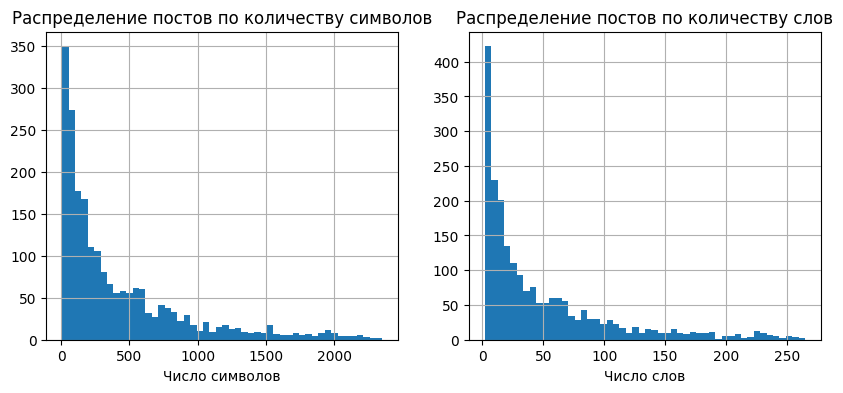

In [39]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df_lem.num_chars.hist(bins=50)
plt.title('Распределение постов по количеству символов'), plt.xlabel('Число символов')
plt.subplot(1, 2, 2)
df_lem.num_words.hist(bins=50)
plt.title('Распределение постов по количеству слов'), plt.xlabel('Число слов');

In [40]:
# характеристики постов по символам
df_lem.num_chars.describe()

count    2109.000000
mean      423.779516
std       482.325041
min         7.000000
25%        81.000000
50%       229.000000
75%       586.000000
max      2351.000000
Name: num_chars, dtype: float64

In [41]:
# характеристики постов по словам
df_lem.num_words.describe()

count    2109.000000
mean       48.344239
std        54.759358
min         2.000000
25%         9.000000
50%        27.000000
75%        67.000000
max       265.000000
Name: num_words, dtype: float64

Большая часть постов короткие. Медианный размер поста 229 символов 27 слов. Наверно есть смысл отбросить посты менее 100 символов и 10 слов.

In [42]:
# оценка датасета после фильтрации
df_lem.query('num_chars >= 100 and num_words >= 10').info()

<class 'pandas.core.frame.DataFrame'>
Index: 1490 entries, 1 to 2117
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_id          1490 non-null   object
 1   post_lemmatized  1490 non-null   object
 2   likes            1490 non-null   int64 
 3   comments         1490 non-null   int64 
 4   reposts          1490 non-null   int64 
 5   num_chars        1490 non-null   int64 
 6   num_words        1490 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 93.1+ KB


In [43]:
# оценка мелких текстов
df_lem.query('num_chars < 100 and num_words < 10').post_lemmatized.head()

3                                  подкаст миражи эпизод ошибка невозвратный затрат
4                                                новый эпизод эффект икеа платформа
7                                                            новый эпизод платформа
10              новый эпизод подкаст говорить парапланеризм совмещаться работа айти
17    написать день статья технократия работать процесс изменений залетать почитать
Name: post_lemmatized, dtype: object

In [44]:
# оценка медианных текстов
df_lem.query('num_chars == 229 or num_words == 27').post_lemmatized.head()

50     разработать приложение помогать действовать будущее учёный быстро решать монотонный задачи связанный проведение эксперимент биологический лабораториях создать мобильный приложение английский языке предусмотреть необходимый функционал научный исследование биолабораториях подробно
270                                                                      друзья нужный дизайнерпросить помочь найти работа благодарный признателен готовый отжать первый заработка каждый день всё большой разочаровываться площадка поиск работы всё дело навыках помочь друга референс опыту
351                           спорить заказчик инфографик подойти хороший объяснение работа приложение строителейпросить помочь оценить инфографик являться информативной просто оставить цифра комментариях возможности рассказать почемуть умышленно писать говорить пример заказчика пример
382                                                       праздником коллега деть программист праздник программистов отмечать день года чис

In [45]:
# оценка больших текстов
df_lem.query('num_chars >= 2000 and num_words >= 200').post_lemmatized.head()

38                                                                 сегодня произойти ситуация взять утро июнь экскурсия аквапарк человек старший детей оплата перевод тинькофф гид отеля ночью средний дочь становиться плохо тошнит день температура понятный дело завтра никуда поедем писать гид отменить поездка вернуть деньги ответ прийти скриншот пользовательский соглашение следующий условиями возврат деньга возможный спустя час бронирование поездка час бронирование поездка возврат стоимость переть пункт поездка остаться менее часов деньга возврат подлежат поздний час заказ деньга возврат подлежать вызвать ребёнок скорый справка медиков любой расклад ребёнок вернуть деньги вызов скорый евро остальной покрывать страховка половина стоимость билета оплатить ещё пара час потратить общение врач оформление документов ребёнок настолько плохо вызывать скорую естественно никто давать почитать договор бронирование предоплата билета всё пишу посетовать судьбу видеть случай аж несколько аналогия бизн